In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
data = data.drop(columns=['Outcome'])


In [17]:
# BMI를 클래스(범주)로 변환
def bmi_to_class(bmi):
    if bmi < 18.5:
        return 0  # 저체중
    elif bmi < 25:
        return 1  # 정상
    elif bmi < 30:
        return 2  # 과체중
    else:
        return 3  # 비만

data['BMI_class'] = data['BMI'].apply(bmi_to_class)

In [18]:
# 데이터와 타겟 분리
X = data.drop(['BMI', 'BMI_class'], axis=1).values
y = data['BMI_class'].values

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [21]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long).unsqueeze(1)


In [22]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [52]:
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesClassifier()

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
train_losses = []
train_accuracies = []
test_accuracies = []

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1))

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # 정확도 계산 추가
        _, predicted = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스
        labels_flat = labels.view(-1)        # [batch_size]

        total += labels_flat.size(0)
        correct += (predicted == labels_flat).sum().item()

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / total * 100
    train_accuracies.append(train_epoch_accuracy)

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스
            labels_flat = labels.view(-1)        # [batch_size]
    
            total += labels_flat.size(0)
            correct += (predicted == labels_flat).sum().item()

    
    test_epoch_accuracy = correct / total * 100
    test_accuracies.append(test_epoch_accuracy)
            

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, Test Accuracy: {test_epoch_accuracy:.2f}%")

print("Training complete.")


Epoch 1/100, Loss: 0.4634, Train Accuracy: 49.51%, Test Accuracy: 56.49%
Epoch 2/100, Loss: 0.4634, Train Accuracy: 62.70%, Test Accuracy: 56.49%
Epoch 3/100, Loss: 0.4634, Train Accuracy: 62.70%, Test Accuracy: 56.49%
Epoch 4/100, Loss: 0.4634, Train Accuracy: 62.70%, Test Accuracy: 56.49%
Epoch 5/100, Loss: 0.4634, Train Accuracy: 62.70%, Test Accuracy: 56.49%
Epoch 6/100, Loss: 0.4634, Train Accuracy: 62.87%, Test Accuracy: 55.84%
Epoch 7/100, Loss: 0.4634, Train Accuracy: 63.19%, Test Accuracy: 55.19%
Epoch 8/100, Loss: 0.4634, Train Accuracy: 63.68%, Test Accuracy: 55.84%
Epoch 9/100, Loss: 0.4634, Train Accuracy: 63.84%, Test Accuracy: 57.79%
Epoch 10/100, Loss: 0.4634, Train Accuracy: 65.15%, Test Accuracy: 59.09%
Epoch 11/100, Loss: 0.4634, Train Accuracy: 64.66%, Test Accuracy: 57.79%
Epoch 12/100, Loss: 0.4634, Train Accuracy: 65.64%, Test Accuracy: 61.04%
Epoch 13/100, Loss: 0.4634, Train Accuracy: 65.64%, Test Accuracy: 61.69%
Epoch 14/100, Loss: 0.4634, Train Accuracy: 65.

In [55]:
# 모델 평가

In [56]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')


Confusion Matrix:
[[ 0  1  0  4]
 [ 0  9  3  5]
 [ 0  8  9 28]
 [ 0  8  7 72]]
F1 Score: 0.54
Precision: 0.55
Recall: 0.58
Specificity: 0.81


/Users/park-yeonseo/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


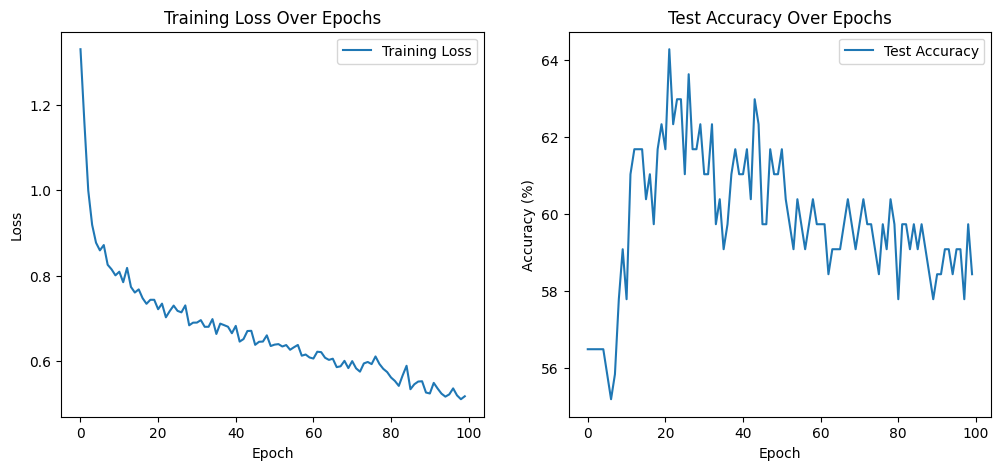

In [57]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

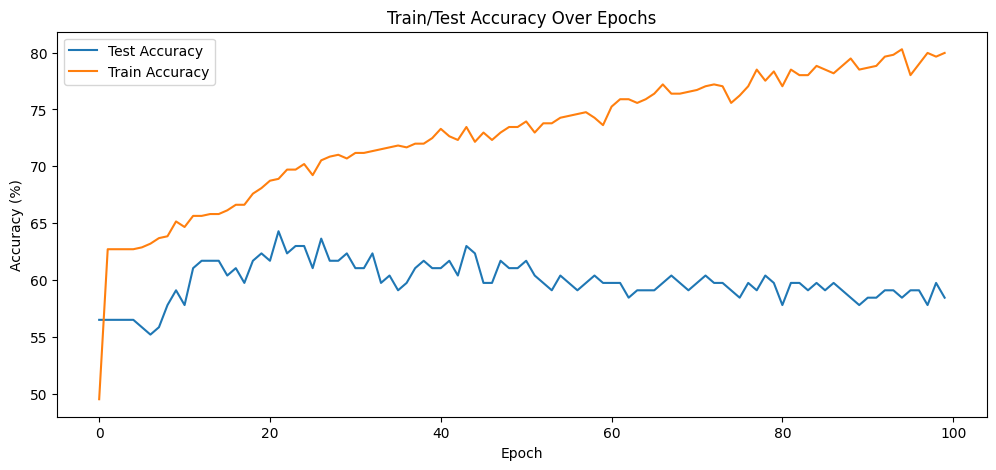

In [58]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))


# Plot accuracy
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy Over Epochs')
plt.legend()

plt.show()